# Numerical Solvers

This notebook explains how to use the numerical solvers of the masters thesis "Wave propagation aided by Deep Learning" by Luis Kaiser, supervised by Prof. Tsai (University of Texas Austin) and Prof. Klingenberg (University of Wuerzburg), in practice. More information about the algorithm can be found in my [code](https://github.com/utkaiser/masterthesis_code) or [writeup](https://github.com/utkaiser/masterthesis_writing).

First, install all necessary libraries specified in `requirements.txt` using `pip` or `pip3` depending on your setup by running the command below.

In [ ]:
!pip3 install --upgrade pip
!pip3 install -r requirements.txt

Generally, the velocity Verlet algorithm and the Runge-Kutta 4 algorithm are used to advance a two-dimensional wave field in a complex medium. By running the code below, we deploy one of the solvers for 10 time steps starting with an initial gaussian pulse. This setup solves the wave equation with periodic boundary conditions. For absorbing boundary conditions, small modifications have to be made: First use the `velocity_verlet_tensor` implementation and use the parameter `boundary_c = absorbing`. Then, change the inputs `u, ut` to the function `velocity_verlet_tensor` to `torch.Tensor`.

Velocity profile


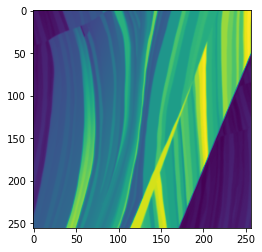

Advancement of two-dimensional wave fields using pseudo-spectral:


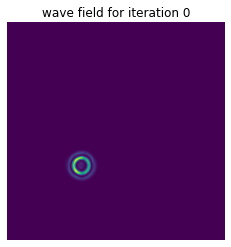

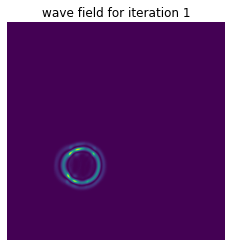

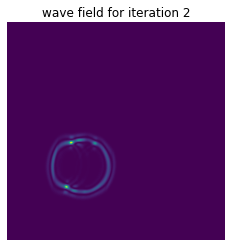

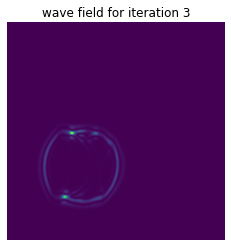

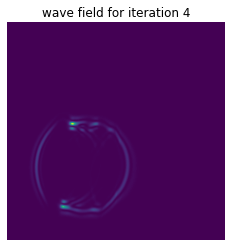

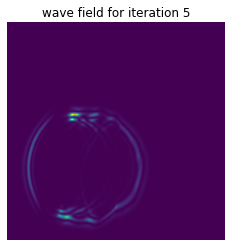

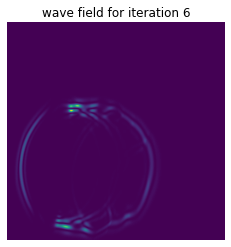

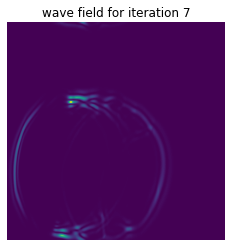

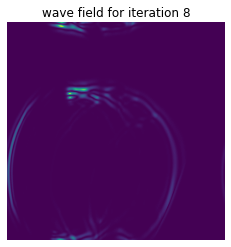

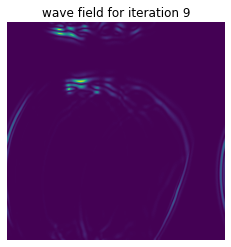

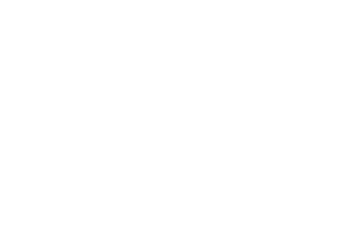

In [1]:
import matplotlib.pyplot as plt
from generate_data.initial_conditions import initial_condition_gaussian
import numpy as np
from generate_data.utils_wave import WaveEnergyField
from generate_data.wave_propagation import pseudo_spectral, velocity_verlet


def get_velocity_model(
        data_path,
        visualize = True
):
    '''

    Parameters
    ----------
    data_path : (string) path to velocity profile crops
    visualize : (boolean) whether to visualize data

    Returns
    -------
    (numpy array) single velocity profile
    '''

    # choose first velocity profile out of list of velocity crops
    vel = np.load(data_path)['wavespeedlist'].squeeze()[0]

    if visualize:
        print("Velocity profile")
        plt.imshow(vel)
        plt.show()
        plt.axis("off")

    return vel


def vis_ps_batched(
        vel_data_path = "../data/velocity_profiles/crops_bp_m_200_256.npz",
        method = "pseudo-spectral",
        res = 128,
        dx = 2./128.,
        dt = 1/600.,
        dt_star = .06
):
    '''

    Parameters
    ----------
    vel_data_path : (string) path to velocity profile crops
    method : (string) "pseudo-spectral" or "velocity-verlet"
    res : (int) dimensionality of the input
    dx : (float) spatial step size numerical solver
    dt : (float) temporal step size numerical solver
    dt_star : (float) time interval the solver is applied once

    Returns
    -------
    10 advancements of timestep dt_star with periodic boundary conditions
    '''

    vel = get_velocity_model(vel_data_path)

    print(f"Advancement of two-dimensional wave fields using {method}:")

    # computing initial condition using gaussian pulse (switch to pytorch tensor if needed)
    u, ut = initial_condition_gaussian(
        vel,
        res=res,
        boundary_condition="periodic",
        mode="parareal",
        res_padded=128 * 2,
        optimization=None
    )

    for s in range(10):

        # run one iteration of the RK4 method for time dt_star and step size dx, time increment dt
        u, ut = pseudo_spectral(u, ut, vel, dx, dt, dt_star)  # alternative: u, ut = velocity_verlet(u, ut, vel, dx, dt, dt_star)

        # change representation to energy semi-norm
        w = WaveEnergyField(u,ut,vel, dx)

        # visualize results
        plt.axis("off")
        plt.imshow(w)
        plt.title(f"wave field for iteration {s}")
        plt.show()


if __name__ == '__main__':
    vis_ps_batched()